In [149]:
import sagemaker
sagemaker.get_execution_role()

'arn:aws:iam::203378532510:role/service-role/AmazonSageMaker-ExecutionRole-Interns'

In [150]:
import json
import os
import pickle as pkl
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings("ignore")

import AIPT.Models.Beshnova2020.CNN
import AIPT.Utils.logging
import AIPT.Utils.plotting

import AIPT.Utils.Dev.dev_utils as dev_utils

aipt_path = '/home/ec2-user/SageMaker/antibody-in-pytorch/'
aipt_reload = dev_utils.get_aipt_reload_fn(aipt_path)

os.chdir(aipt_path)
print("current working directory:")
%pwd

current working directory:


'/home/ec2-user/SageMaker/antibody-in-pytorch'

In [151]:
'''
set up paths
'''

aipt_dir = '/home/ec2-user/SageMaker/antibody-in-pytorch/AIPT' # replace with your own aipt path
# print("\t".join(os.listdir(aipt_dir)))
!ls {aipt_dir}

Benchmarks	__init__.py  Models	  Utils
entry_point.py	__main__.py  __pycache__


In [152]:
'''
Run settings
'''

SEQ_LENGTH = 12 # CDR3 AA length
toy = True # if True, use smaller dataset
toy_rows = 50 # if `toy`, use at most `toy_rows` OAS data files

start_tensorboard = True # Start TensorBoard server. TensorBoard logging occurs even if False.

seq_dir = os.path.join(aipt_dir, "Benchmarks/OAS_dataset/data/seq_db") # Sequence directory
model_dir = 'AIPT/Models/Beshnova2020'
model_dir_abs = os.path.join(aipt_path, model_dir)

## Data Processing

In [153]:
import pandas as pd
# %cd {model_dir_abs}
index_fn = "OAS_index.txt"
index_path = os.path.join(aipt_path, model_dir, index_fn)
full_index_path = os.path.join(aipt_path, 'AIPT', 'Benchmarks', 'OAS_dataset', 'data', 'OAS_meta_info.txt')
toy_index_path = os.path.join(model_dir_abs, 'OAS_index_small.txt')
input_seq_type = "CDR3"
output_field = "BType"
cell_types = [
    "Naive-B-Cells",
    "Memory-B-Cells",
] 

index_path_to_read = toy_index_path if toy else full_index_path
index_df = pd.read_csv(index_path_to_read, sep='\t')

def index_filter(row):
    # filter the data for files with desired cell type annotations
    return row['BType'] in cell_types and row['Species'] == 'human'

index_df_filtered = index_df[index_df.apply(index_filter, axis=1)]
index_df_filtered.to_csv(index_path, sep='\t')

In [154]:
from AIPT.Models.Beshnova2020.data import load_data, get_train_test_loaders

index_df = pd.read_csv(index_path, sep="\t")
file_names = index_df['file_name']
file_names
data = load_data(index_df, seq_dir, cell_types, seq_len=SEQ_LENGTH)
train_loader, test_loader = get_train_test_loaders(data)
data

,CDR3_aa,BType,label
1,AREYARHNPGGD,Memory-B-Cells,1
2,TRPNGGDYAFDI,Memory-B-Cells,1
17,VKDWGGSYHFDR,Memory-B-Cells,1
26,ASSWYGGYYFDY,Memory-B-Cells,1
27,ARDKGASYYFDY,Memory-B-Cells,1
...,...,...,...
1527,ARGGTGTTNFGY,Naive-B-Cells,0
1530,ARLTGTHPYFDY,Naive-B-Cells,0
1533,ARVSVSTGWFDP,Naive-B-Cells,0
1535,ARLDRTVYGMDV,Naive-B-Cells,0


## Load Model

In [155]:
aipt_reload(AIPT.Models.Beshnova2020.CNN)
aipt_reload(AIPT.Utils.logging)
aipt_reload(AIPT.Utils.plotting)
from AIPT.Models.Beshnova2020.CNN import CNN
import AIPT.Models.Beshnova2020.pca_embedding as pca_embedding
from AIPT.Utils.logging import today, current_time
from AIPT.Utils.plotting import plot_roc_curves, roc_from_models


File: /home/ec2-user/SageMaker/.persisted_conda/aipt/lib/python3.6/site-packages/AIPT-0.0.1-py3.6.egg/AIPT/Models/Beshnova2020/CNN.py 
 Last modified: 2020-11-11 11:38:50 UTC




In [156]:
import os

# log_root_dir = '/home/ec2-user/SageMaker/logs/tensorboard'
log_root_dir = 's3://gv20interns/roger/logs/tensorboard'
run_name = 'plots'
timezone = 'EST'

# original para_dict
# para_dict = {
#     'seq_len': SEQ_LENGTH,
#     'embedding_dim': 15, # paper uses dim 15 PCA features
#     'epoch': 300,
#     'classes': cell_types,
#     'learning_rate': 10**-3,
#     'run_name': run_name,
#     'log_dir': os.path.join(log_root_dir, today(tz=timezone), run_name, current_time(tz=timezone)),
# }

para_dict = {
    'seq_len': SEQ_LENGTH,
    'classes': cell_types,
    'embedding_dim': 15,  # paper uses dim 15 PCA features
    'index_file': 'OAS_index_small.txt',
    'batch_size': 100,
    'epoch': 1000,
    'run_name': run_name,
    'work_path': os.path.join(model_dir_abs, 'models'),
    # tuned hyperparameters from https://us-east-2.console.aws.amazon.com/sagemaker/home?region=us-east-2#/hyper-tuning-jobs/roger-beshnova2020-t-201103-0809
    'learning_rate': 0.000125245489276611,
    'dropout_rate': 0.1554058115760688,
    'conv1_filter_dim1': 2,
    'conv1_n_filters': 17,
    'conv2_filter_dim1': 1,
    'conv2_n_filters': 16,
    'max_pool_filter_dim1': 1,
    'fc_hidden_dim': 83,
    'log_dir': os.path.join(log_root_dir, today(tz=timezone), run_name, current_time(tz=timezone)),
}
print('LOG DIR:', para_dict['log_dir'])

pca_model = CNN.pca_model({'model_name': 'pca', **para_dict})
general_model = CNN.general_model({'model_name': 'general', **para_dict})

LOG DIR: s3://gv20interns/roger/logs/tensorboard/2020-11-11/plots/06.38.54


## Tensorboard

In [157]:
import subprocess as sp


if start_tensorboard:
    tensorboard_proc = sp.Popen(
        [
            "tensorboard",
            "--logdir",
            para_dict["log_dir"],
        ],
        universal_newlines=True,
        stdout=sp.PIPE,
        stderr=sp.PIPE,
    )

## Train

In [158]:
print('PCA')
pca_model.fit(train_loader, test_loader=test_loader)
print('\n\n\n')
print('GENERAL')
general_model.fit(train_loader, test_loader=test_loader)

PCA
Found saved model from: Epoch 1000

EPOCH 1000:

TRAIN:
Total Loss=67.43 Average Loss=1.02e-02
[[  59  245]
 [  11 1797]]
Accuracy = 0.879, MCC = 0.369
------------------------------
TEST:
Total Loss=18.97 Average Loss=1.19e-02
[[ 16  58]
 [  5 433]]
Accuracy = 0.877, MCC = 0.363
------------------------------

best_epoch=1000; best_test_mcc=0.3631064299379335;






GENERAL
Found saved model from: Epoch 1000

EPOCH 1000:

TRAIN:
Total Loss=58.26 Average Loss=8.83e-03
[[  66  236]
 [  13 1797]]
Accuracy = 0.882, MCC = 0.390
------------------------------
TEST:
Total Loss=18.86 Average Loss=1.18e-02
[[  8  66]
 [  3 435]]
Accuracy = 0.865, MCC = 0.246
------------------------------

best_epoch=1000; best_test_mcc=0.24556725526110323;




{'train': {'loss': tensor(58.2634),
  'cm': array([[  66,  236],
         [  13, 1797]]),
  'acc': 0.8821022727272727,
  'mcc': 0.3899283534078383},
 'test': {'loss': tensor(18.8640),
  'cm': array([[  8,  66],
         [  3, 435]]),
  'acc': 0.865234375,
  'mcc': 0.24556725526110323,
  'best_mcc': 0.24556725526110323,
  'best_epoch': 1000}}

In [159]:
# load pretrained best models
# pca_model.net_init()
# pca_model.load_best()
# general_model.net_init()
# general_model.load_best()

## Evaluation

In [160]:
def model_evaluation(data_loader, data_name, figure_dir, figure_basename, title_basename):
    figure_path = os.path.join(figure_dir, f'{figure_basename}_{data_name}.png')
    roc_from_models(
        {
            pca_model.name.upper(): pca_model,
            general_model.name.capitalize(): general_model,
        },
        {
            pca_model.name.upper(): data_loader,
            general_model.name.capitalize(): data_loader,
        },
        title=f"{title_basename} ({data_name.capitalize()})",
        save_path=figure_path
    )

figure_dir = os.path.join(model_dir_abs, 'figures')
figure_basename = 'memory_naive_roc'
title_basename = 'Memory vs. Naive B-Cell Classification'

### Train Eval

PCA:
Total Loss=67.43 Average Loss=1.02e-02
[[  59  245]
 [  11 1797]]
Accuracy = 0.879, MCC = 0.369
------------------------------
General:
Total Loss=58.46 Average Loss=8.86e-03
[[  66  237]
 [  13 1796]]
Accuracy = 0.882, MCC = 0.389
------------------------------
Saved to: /home/ec2-user/SageMaker/antibody-in-pytorch/AIPT/Models/Beshnova2020/figures/memory_naive_roc_train.png


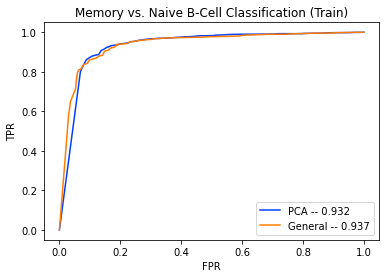

<Figure size 432x288 with 0 Axes>

In [161]:
model_evaluation(train_loader, 'train', figure_dir, figure_basename, title_basename)

### Test Eval

PCA:
Total Loss=18.97 Average Loss=1.19e-02
[[ 16  58]
 [  5 433]]
Accuracy = 0.877, MCC = 0.363
------------------------------
General:
Total Loss=18.86 Average Loss=1.18e-02
[[  8  66]
 [  3 435]]
Accuracy = 0.865, MCC = 0.246
------------------------------
Saved to: /home/ec2-user/SageMaker/antibody-in-pytorch/AIPT/Models/Beshnova2020/figures/memory_naive_roc_test.png


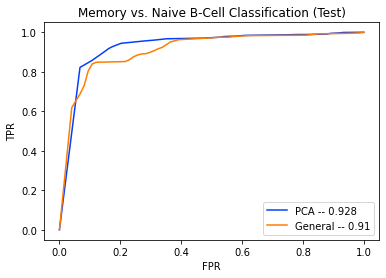

<Figure size 432x288 with 0 Axes>

In [162]:
model_evaluation(test_loader, 'test', figure_dir, figure_basename, title_basename)

## The Effect of Length

In [163]:
import os
aipt_reload(AIPT.Utils.plotting)
from AIPT.Utils.plotting import roc_from_models
from AIPT.Models.Beshnova2020.data import seed_random

def length_roc(para_dict, embedding_name, model_getter, len_range=range(12,17)):
    models = {}
    test_loaders = {}
    length_dir = os.path.join(model_dir_abs, "results", "length")
    for length in len_range:
        print(f'Processing length {length} seqs...')
        para_dict = para_dict.copy()
        para_dict["seq_len"] = length
        data = load_data(index_df, seq_dir, cell_types, seq_len=length)
        seed_random()
        _, test_loader = get_train_test_loaders(data)
        test_loaders[str(length)] = test_loader
        model_weights_path = os.path.join(
            length_dir, str(length), f"{embedding_name}_100", "model", "best"
        )
        para_dict = para_dict.copy()
        para_dict['model_name'] = f'embedding_name_length'
        model = model_getter(para_dict)
        model.net_init()
        model.load_state_dict(torch.load(model_weights_path))
        models[str(length)] = model
    save_path = os.path.join(length_dir, f"{embedding_name}.png")
    roc_from_models(
        models, test_loaders, title=f"Effect of CDR3 Length", save_path=save_path
    )

### PCA

Processing length 12 seqs...
Processing length 13 seqs...
Processing length 14 seqs...
Processing length 15 seqs...
Processing length 16 seqs...
12:
Total Loss=6.40 Average Loss=4.00e-03
[[ 78   3]
 [ 39 392]]
Accuracy = 0.918, MCC = 0.758
------------------------------
13:
Total Loss=8.14 Average Loss=5.43e-03
[[ 76   3]
 [ 80 321]]
Accuracy = 0.827, MCC = 0.604
------------------------------
14:
Total Loss=10.37 Average Loss=5.76e-03
[[ 77   9]
 [ 74 416]]
Accuracy = 0.856, MCC = 0.603
------------------------------
15:
Total Loss=8.28 Average Loss=5.17e-03
[[114   8]
 [101 289]]
Accuracy = 0.787, MCC = 0.583
------------------------------
16:
Total Loss=10.93 Average Loss=9.94e-03
[[ 66   0]
 [ 41 245]]
Accuracy = 0.884, MCC = 0.727
------------------------------
Saved to: /home/ec2-user/SageMaker/antibody-in-pytorch/AIPT/Models/Beshnova2020/results/length/pca.png


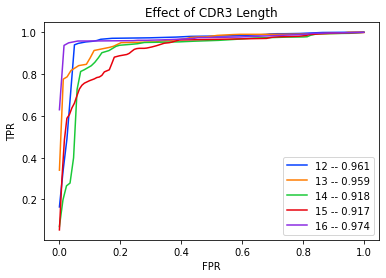

<Figure size 432x288 with 0 Axes>

In [164]:
length_roc(para_dict, 'pca', CNN.pca_model)

### General

Processing length 12 seqs...
Processing length 13 seqs...
Processing length 14 seqs...
Processing length 15 seqs...
Processing length 16 seqs...
12:
Total Loss=5.70 Average Loss=3.56e-03
[[ 75   6]
 [ 31 400]]
Accuracy = 0.928, MCC = 0.769
------------------------------
13:
Total Loss=6.99 Average Loss=4.66e-03
[[ 76   3]
 [ 71 330]]
Accuracy = 0.846, MCC = 0.631
------------------------------
14:
Total Loss=9.83 Average Loss=5.46e-03
[[ 81   5]
 [105 385]]
Accuracy = 0.809, MCC = 0.555
------------------------------
15:
Total Loss=8.47 Average Loss=5.30e-03
[[114   8]
 [109 281]]
Accuracy = 0.771, MCC = 0.563
------------------------------
16:
Total Loss=11.01 Average Loss=1.00e-02
[[ 66   0]
 [ 19 267]]
Accuracy = 0.946, MCC = 0.851
------------------------------
Saved to: /home/ec2-user/SageMaker/antibody-in-pytorch/AIPT/Models/Beshnova2020/results/length/general.png


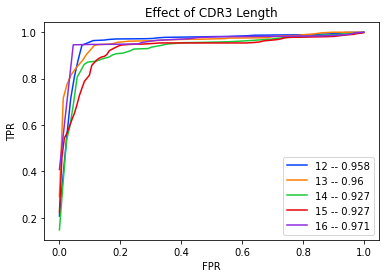

<Figure size 432x288 with 0 Axes>

In [165]:
length_roc(para_dict, 'general', CNN.general_model)

## Test on DeepCAT dataset

In [166]:
aipt_reload(AIPT.Models.Beshnova2020.CNN)
aipt_reload(AIPT.Utils.logging)
aipt_reload(AIPT.Utils.plotting)
from AIPT.Models.Beshnova2020.CNN import CNN
from AIPT.Models.Beshnova2020.data import get_data_loader
import AIPT.Models.Beshnova2020.pca_embedding as pca_embedding
from AIPT.Utils.logging import today, current_time
from AIPT.Utils.plotting import plot_roc_curves


File: /home/ec2-user/SageMaker/.persisted_conda/aipt/lib/python3.6/site-packages/AIPT-0.0.1-py3.6.egg/AIPT/Models/Beshnova2020/CNN.py 
 Last modified: 2020-11-11 11:39:09 UTC




In [167]:
log_root_dir = 's3://gv20interns/roger/logs/tensorboard'
run_name = 'deepcat_test'
timezone = 'EST'

para_dict = {
#     'seq_len': 12,
    'embedding_dim': 15, # paper uses dim 15 PCA features
#     'epoch': 1000,
    'classes': ['normal', 'tumor'],
    'learning_rate': 10**-3,
    'run_name': run_name,
    'log_dir': os.path.join(log_root_dir, today(tz=timezone), run_name, current_time(tz=timezone)),
    'work_path': os.path.join(model_dir_abs, 'work/DeepCAT')
}



In [168]:
import pandas as pd

# data is copied from https://github.com/s175573/DeepCAT/tree/master/TrainingData
data_dir = os.path.join(model_dir_abs, 'data')
fnormal = os.path.join(data_dir, 'NormalCDR3.txt')
ftumor = os.path.join(data_dir, 'TumorCDR3.txt')

def load_deepcat_data(ftumor, fnormal, seq_len = 12):
    # copied from https://github.com/s175573/DeepCAT/blob/master/DeepCAT.py
    tumorCDR3s=[]
    g=open(ftumor)
    for ll in g.readlines():
        rr=ll.strip()
        if not rr.startswith('C') or not rr.endswith('F'):
            print("Non-standard CDR3s. Skipping.")
            continue
        if len(rr) != seq_len:
            continue
        tumorCDR3s.append(rr)
    normalCDR3s=[]
    g=open(fnormal)
    for ll in g.readlines():
        rr=ll.strip()
        if not rr.startswith('C') or not rr.endswith('F'):
            print("Non-standard CDR3s. Skipping.")
            continue
        if len(rr) != seq_len:
            continue
        normalCDR3s.append(rr)
        
    normal_df = pd.DataFrame(normalCDR3s)
    normal_df.columns = ['CDR3_aa']
    normal_df['label'] = 0

    tumor_df = pd.DataFrame(tumorCDR3s)
    tumor_df.columns = ['CDR3_aa']
    tumor_df['label'] = 1

    data_df = pd.concat([normal_df, tumor_df])
    return data_df
    

In [169]:
seq_lengths = range(12, 17)
accs = {}
for seq_length in seq_lengths:
    
    dc_para_dict = para_dict.copy()
    dc_para_dict['seq_len'] = seq_length
    
    data_df = load_deepcat_data(ftumor, fnormal, seq_len=seq_length)
    print(data_df)
    dc_train_loader = get_data_loader(data_df)
    
    num_batches = len(dc_train_loader)
    dc_steps = 40000
    dc_para_dict['epoch'] = dc_steps//num_batches
    dc_para_dict['model_name'] = f'deepcat_torch_seqlen{seq_length}'
    dc_model = CNN.pca_model(dc_para_dict)
    
    results = dc_model.fit(dc_train_loader)
    accs[seq_length] = results['train']['acc']

           CDR3_aa  label
0     CASSLAVGGYTF      0
1     CASSSRGETQYF      0
2     CASSRTAGELFF      0
3     CASSLAVETQYF      0
4     CASSIIGNEQYF      0
...            ...    ...
2901  CASSSGDSRYTF      1
2902  CSAGAGGDEQYF      1
2903  CATVSSAGELFF      1
2904  CSVATGEYEQYF      1
2905  CASRGATETQYF      1

[7379 rows x 2 columns]
Found saved model from: Epoch 170

EPOCH 170:

TRAIN:
Total Loss=69.51 Average Loss=1.51e-02
[[4270  195]
 [ 737 2158]]
Accuracy = 0.873, MCC = 0.735
------------------------------


            CDR3_aa  label
0     CASSLKPNTEAFF      0
1     CASSPRPNTEAFF      0
2     CASSLDMNYGYTF      0
3     CASSFTGGETQYF      0
4     CASSGGGPTEAFF      0
...             ...    ...
5862  CASSRFAAEKLFF      1
5863  CASSTGVYQPQHF      1
5864  CASTKGGANEQFF      1
5865  CASSTGPLYGYTF      1
5866  CASSLGGYREQYF      1

[14953 rows x 2 columns]
Found saved model from: Epoch 80

EPOCH 80:

TRAIN:
Total Loss=163.51 Average Loss=1.75e-02
[[8216  863]
 [1466 4399]]
Accuracy = 

In [170]:
print(accs)

{12: 0.8733695652173913, 13: 0.8441514989293362, 14: 0.8112129324546952, 15: 0.818603515625, 16: 0.8877840909090909}


   Unnamed: 0  seq_len       acc   Framework
0           0       12  0.914266     PyTorch
1           1       13  0.853854     PyTorch
2           2       14  0.825062     PyTorch
3           3       15  0.832214     PyTorch
4           4       16  0.940199     PyTorch
5           0       12  0.861046  TensorFlow
6           1       13  0.830846  TensorFlow
7           2       14  0.786519  TensorFlow
8           3       15  0.828754  TensorFlow
9           4       16  0.852309  TensorFlow


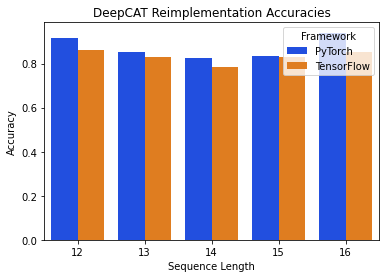

In [171]:
import pandas as pd
import seaborn as sns

pt_results = accs
tf_results = {
    12: 0.8610463741917541,
    13: 0.8308455045175356,
    14: 0.7865194836315643,
    15: 0.82875444017,
    16: 0.85230856924342,
}
def get_results_df(results_dict, framework):
    lengths = results_dict.keys()
    accs = results_dict.values()
    df = pd.DataFrame.from_dict({'seq_len': lengths, 'acc': accs})
    df['Framework'] = framework
    return df


df_path = os.path.join(model_dir_abs, 'comparison.csv')
if os.path.isfile(df_path):
    df = pd.read_csv(df_path)
else:
    pt_df = get_results_df(pt_results, framework='PyTorch')
    tf_df = get_results_df(tf_results, framework='TensorFlow')
    df = pd.concat([pt_df, tf_df])
    df.to_csv(df_path)
print(df)

sns.color_palette('bright')
fig = sns.barplot(data=df, x='seq_len', y='acc', hue='Framework')
fig.set(xlabel='Sequence Length', ylabel='Accuracy', title='DeepCAT Reimplementation Accuracies')
fig_path = os.path.join(model_dir_abs, 'comparision.png')
fig.figure.savefig(fig_path, dpi=300)